In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb 

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint

from datetime import timedelta

import plotly.graph_objs as go
import plotly.offline as pyo

import warnings
warnings.filterwarnings('ignore')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
path = '../dasatet_5/BritishMart-morrisons.csv'

bm = pd.read_csv(path)
pd.set_option('display.max_colwidth', None)

In [3]:
# Map sesuai perubahan
unit_mapping = {'kg': 'kg', 'l': 'litre', 'unit': 'ounces', 'm': 'meter'}

bm['unit'] = bm['unit'].replace(unit_mapping)

In [4]:
bm_empty = bm[bm.isna().any(axis=1)]

In [5]:
bm_empty

Empty DataFrame
Columns: [nama_toko, harga_pound, harga_per_unit, unit, nama, kategori, brand_sendiri, tanggal]
Index: []

In [6]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   nama_toko       979866 non-null  object 
 1   harga_pound     979866 non-null  float64
 2   harga_per_unit  979866 non-null  float64
 3   unit            979866 non-null  object 
 4   nama            979866 non-null  object 
 5   kategori        979866 non-null  object 
 6   brand_sendiri   979866 non-null  bool   
 7   tanggal         979866 non-null  object 
dtypes: bool(1), float64(2), object(5)
memory usage: 53.3+ MB


# **Standarization On 'kategori'**

In [7]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

nama_toko  harga_pound  harga_per_unit   unit  \
1       BritishMart          2.1             2.1  litre   
16332   BritishMart          2.1             2.1  litre   
36698   BritishMart          2.1             2.1  litre   
60982   BritishMart          2.1             2.1  litre   
89688   BritishMart          2.1             2.1  litre   
109517  BritishMart          2.1             2.1  litre   
125376  BritishMart          2.1             2.1  litre   
152528  BritishMart          2.1             2.1  litre   
167763  BritishMart          2.1             2.1  litre   
189559  BritishMart          2.1             2.1  litre   

                              nama    kategori  brand_sendiri     tanggal  
1       Alpro Almond Chilled Drink      drinks          False  2021-01-01  
16332   Alpro Almond Chilled Drink   free-from          False  2021-01-20  
36698   Alpro Almond Chilled Drink      drinks          False  2021-02-13  
60982   Alpro Almond Chilled Drink  fresh_food          False  2021-03-13  
89688   Alpro Almond Chilled Drink  fresh_food          False  2021-04-16  
109517  Alpro Almond Chilled Drink  fresh_food          False  2021-05-10  
125376  Alpro Almond Chilled Drink  fresh_food          False  2021-05-28  
152528  Alpro Almond Chilled Drink      drinks          False  2021-06-29  
167763  Alpro Almond Chilled Drink      drinks          False  2021-07-17  
189559  Alpro Almond Chilled Drink      drinks          False  2021-08-12

In [8]:
mode_kategori = bm.groupby('nama')['kategori'].agg(lambda x: x.mode()[0])
bm = pd.merge(bm, mode_kategori, how='left', on='nama', suffixes=('', '_mode'))
bm['kategori'] = bm['kategori_mode']
bm.drop(columns=['kategori_mode'], inplace=True)

In [9]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

nama_toko  harga_pound  harga_per_unit   unit  \
1       BritishMart          2.1             2.1  litre   
16332   BritishMart          2.1             2.1  litre   
36698   BritishMart          2.1             2.1  litre   
60982   BritishMart          2.1             2.1  litre   
89688   BritishMart          2.1             2.1  litre   
109517  BritishMart          2.1             2.1  litre   
125376  BritishMart          2.1             2.1  litre   
152528  BritishMart          2.1             2.1  litre   
167763  BritishMart          2.1             2.1  litre   
189559  BritishMart          2.1             2.1  litre   

                              nama   kategori  brand_sendiri     tanggal  
1       Alpro Almond Chilled Drink  free-from          False  2021-01-01  
16332   Alpro Almond Chilled Drink  free-from          False  2021-01-20  
36698   Alpro Almond Chilled Drink  free-from          False  2021-02-13  
60982   Alpro Almond Chilled Drink  free-from          False  2021-03-13  
89688   Alpro Almond Chilled Drink  free-from          False  2021-04-16  
109517  Alpro Almond Chilled Drink  free-from          False  2021-05-10  
125376  Alpro Almond Chilled Drink  free-from          False  2021-05-28  
152528  Alpro Almond Chilled Drink  free-from          False  2021-06-29  
167763  Alpro Almond Chilled Drink  free-from          False  2021-07-17  
189559  Alpro Almond Chilled Drink  free-from          False  2021-08-12

In [10]:
bm_cleaned = bm.loc[:,['harga_per_unit', 'nama', 'tanggal', 'brand_sendiri', 'unit', 'kategori']]
bm_cleaned['tanggal'] = pd.to_datetime(bm_cleaned['tanggal'])
bm_cleaned.index = bm_cleaned.pop('tanggal')
bm_cleaned.sort_index(inplace=True)

# **Extract Brand Name**

In [11]:
nama_produk = bm_cleaned['nama'].value_counts()

In [12]:
nama_produk.head(10)

nama
Alpro Oat Long Life Drink                   49
Calpol Nasal Drops                          49
Tena Silhouette Pants Black L               49
Vaseline Lip Therapy With Aloe Vera         49
Peach Pure Tea Tree Oil                     49
Always Discreet Boutique Incontinence P…    49
Always Discreet Underwear Bou…              49
Fulfil Chocolate Salted Caram…              49
Calpol Sugar Free Infant Sachets            49
Naturya Flaxseed Mix Berry                  49
Name: count, dtype: int64

In [13]:
from collections import defaultdict, Counter

word_pairs_counts = Counter()
first_word_counts = Counter()

for name in bm_cleaned['nama']:
    name = name.lower()
    words = name.split()
    if len(words) >= 2:
        word_pairs_counts[(words[0], words[1])] += 1
        first_word_counts[words[0]] += 1

word_pairs_grouped = defaultdict(list)
for (first_word, second_word), count in word_pairs_counts.items():
    word_pairs_grouped[first_word].append((second_word, count))

most_common_word_pairs_combined = {
    first_word: sorted(second_words, key=lambda x: x[1], reverse=False)
    for first_word, second_words in word_pairs_grouped.items()
}

df_pair = pd.DataFrame(columns=['First Word', 'Second Word', 'Count', 'First Word Count'])

for first_word, second_words in most_common_word_pairs_combined.items():
    for second_word, count in second_words:
        df_pair = pd.concat([df_pair, pd.DataFrame({
            'First Word': [first_word],
            'Second Word': [second_word],
            'Count': [count],
            'First Word Count': [first_word_counts[first_word]]
        })], ignore_index=True)

In [14]:
df_pair.rename(columns={
    'Count': 'Second Word Count'
}, inplace=True)

In [15]:
df_pair[df_pair['First Word'] == 'blue']

First Word Second Word Second Word Count First Word Count
2985       blue        with                33             2066
2986       blue           2                33             2066
2987       blue         bio                40             2066
2988       blue       ridge                44             2066
2989       blue           &                46             2066
2990       blue      orange                47             2066
2991       blue         new                48             2066
2992       blue     diamond                49             2066
2993       blue        moon                90             2066
2994       blue      riband               103             2066
2995       blue      dragon              1533             2066

In [16]:
filtered_first = df_pair[df_pair['First Word Count'] > df_pair['Second Word Count']]
first_name_brand = filtered_first[['First Word']].rename(columns={'First Word': 'brand_name'})

filtered_second = df_pair[df_pair['First Word Count'] == df_pair['Second Word Count']]
filtered_second['brand_name'] = filtered_second['First Word'] + ' ' + filtered_second['Second Word']
two_name_brand = filtered_second[['brand_name']]

first_name_brand = first_name_brand.drop_duplicates()
two_name_brand = two_name_brand.drop_duplicates()

brands_name = pd.concat([first_name_brand, two_name_brand], ignore_index=True)

In [17]:
brands_name

brand_name
0                   alpro
1                innocent
2                highland
3                  radnor
4               morrisons
...                   ...
2759  mediterranean magic
2760     montys pineapple
2761             yogi tea
2762       snacksters big
2763           birdseye 2

[2764 rows x 1 columns]

In [18]:
bm_cleaned['brand'] = None
bm_cleaned['nama_lower'] = bm_cleaned['nama'].str.lower()

In [19]:
known_brands_list = brands_name['brand_name'].tolist()

In [20]:
def extract_brand(nama, known_brands):
    nama_words = nama.lower().split()
    for i in range(len(nama_words)):
        for j in range(i+1, len(nama_words)+1):
            candidate = ' '.join(nama_words[i:j])
            if candidate in known_brands:
                return candidate
    return None

bm_cleaned['brand'] = bm_cleaned['nama'].apply(lambda x: extract_brand(x, known_brands_list))
bm_cleaned = bm_cleaned.drop('nama_lower', axis=1)

# **Clean Data By Brand**

In [21]:
avg_harga_per_brand = bm_cleaned.groupby(['tanggal', 'brand'])['harga_per_unit'].mean().reset_index()
avg_harga_per_brand.columns = ['tanggal', 'brand', 'avg_harga_brand']

bm_cleaned_new = bm_cleaned.merge(avg_harga_per_brand, on=['tanggal', 'brand'], how='left')
df_new = bm_cleaned_new.groupby(['unit', 'brand_sendiri', 'tanggal', 'brand']).agg({'avg_harga_brand': 'mean'}).reset_index()

brand_counts = df_new['brand'].value_counts()

brands_to_keep = brand_counts[brand_counts >= 790].index
bm_new = df_new[df_new['brand'].isin(brands_to_keep)]

bm_new['tanggal'] = pd.to_datetime(bm_new['tanggal'])
bm_new.index = bm_new.pop('tanggal')
bm_new.sort_index(inplace=True)

# **Select Brand Example**

In [22]:
bm_new['brand'].value_counts()

brand
morrisons    3351
nutmeg       2228
the          1725
cadbury      1404
john         1254
old          1142
nivea        1119
mr           1090
heinz        1062
oral-b       1007
blue          994
simple        988
dr.           984
gillette      964
market        944
fairy         943
regal         939
colgate       907
ktc           890
st            884
l'oreal       876
alpro         841
good          813
garnier       796
Name: count, dtype: int64

In [23]:
to_keep = ['morrisons', 'nutmeg', 'cadbury', 'nivea', 'heinz', 'oral-b', 'simple', 'gillette', 'fairy', 'regal', 'colgate', 'ktc', "l'oreal", 'alpro', 'garnier']

In [24]:
bm_branded = bm_new[bm_new['brand'] == 'morrisons']

In [25]:
bm_branded.head(3)

unit  brand_sendiri      brand  avg_harga_brand
tanggal                                                     
2021-01-01  litre           True  morrisons         2.182984
2021-01-01     kg           True  morrisons         2.182984
2021-01-02     kg           True  morrisons        12.498444

In [26]:
bm_branded = bm_branded.reset_index()
bm_branded = bm_branded.drop_duplicates(subset='tanggal')

In [27]:
bm_branded.index = bm_branded.pop('tanggal')
bm_branded.sort_index(inplace=True)

In [28]:
bm_branded.index.duplicated().any()

False

# **Features Creation**

In [29]:
def create_features(data):
    data['dayofweek']= data.index.dayofweek
    data['quarter']= data.index.quarter
    data['month']= data.index.month
    data['year']= data.index.year
    data['dayofyear']= data.index.dayofyear
    return data

In [30]:
bm_branded = bm_branded.sort_values(by=['brand', 'tanggal'])
bm_branded['moving_avg_per_triduum'] = bm_branded.groupby('brand')['avg_harga_brand'].rolling(window=3).mean().reset_index(level=0, drop=True)
bm_branded['moving_avg_per_triduum'] = bm_branded['moving_avg_per_triduum'].fillna(0)

In [31]:
def create_lag_feature(df, col_name, lags):
    df_with_lags = df.copy()
    for lag in lags:
        lag_col_name = f'lag_{lag}'
        df_with_lags[lag_col_name] = df_with_lags.groupby('brand')[col_name].shift(lag)
    df_with_lags = df_with_lags.fillna(0)
    return df_with_lags

In [32]:
steps = [1, 3, 5, 7]

bm_branded = create_features(bm_branded)
bm_branded = create_lag_feature(bm_branded, 'avg_harga_brand', steps)

In [33]:
bm_branded = bm_branded.drop('brand', axis=1)
bm_branded = bm_branded.drop('brand_sendiri', axis=1)
bm_branded = bm_branded.drop('unit', axis=1)

In [34]:
bm_branded.head(3)

avg_harga_brand  moving_avg_per_triduum  dayofweek  quarter  \
tanggal                                                                   
2021-01-01         2.182984                0.000000          4        1   
2021-01-02        12.498444                0.000000          5        1   
2021-01-03        14.490435                9.723954          6        1   

            month  year  dayofyear      lag_1  lag_3  lag_5  lag_7  
tanggal                                                             
2021-01-01      1  2021          1   0.000000    0.0    0.0    0.0  
2021-01-02      1  2021          2   2.182984    0.0    0.0    0.0  
2021-01-03      1  2021          3  12.498444    0.0    0.0    0.0

# **Stationarity Check**

In [35]:
bm_stationarity_check = bm_branded[['avg_harga_brand']].copy()
bm_stationarity_check.index = pd.to_datetime(bm_stationarity_check.index)
bm_stationarity_check.index.name = 'tanggal'

In [36]:
result = seasonal_decompose(bm_stationarity_check['avg_harga_brand'], period=13)  

trend = result.trend
seasonal = result.seasonal
residual = result.resid

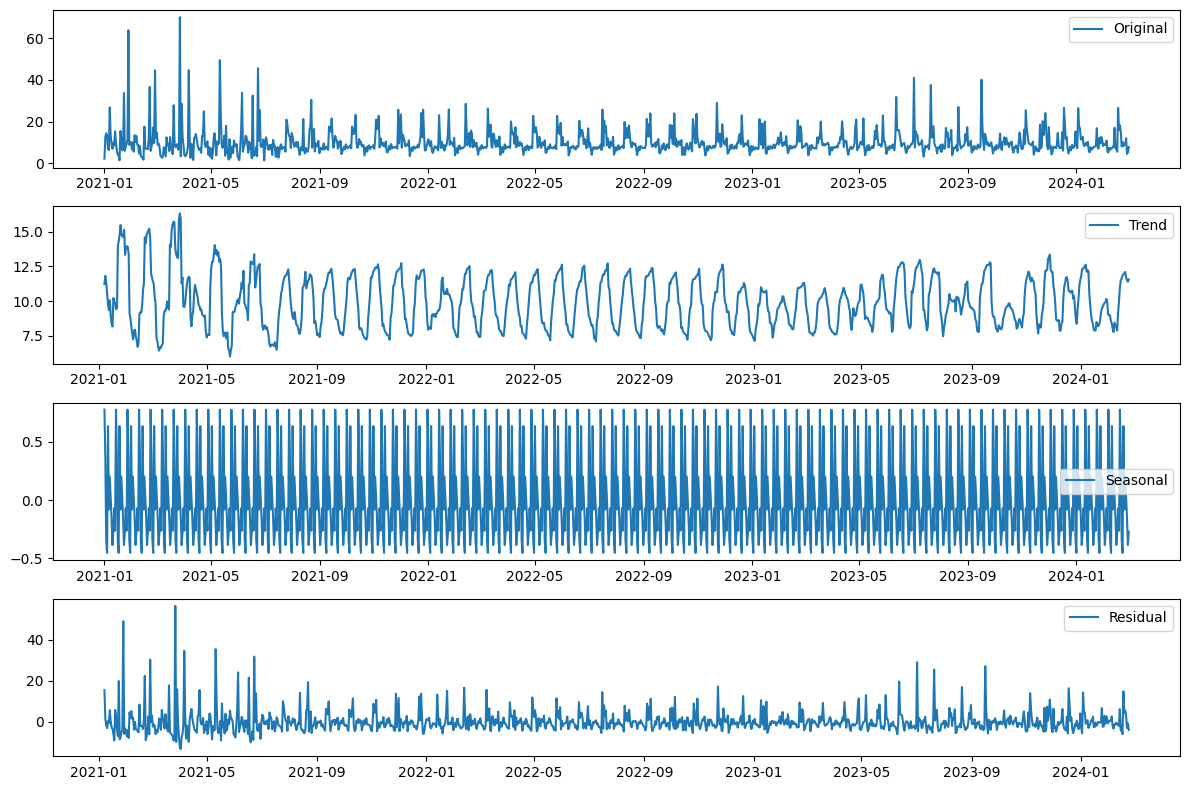

In [37]:
# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(bm_stationarity_check.index, bm_stationarity_check['avg_harga_brand'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(bm_stationarity_check.index, trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(bm_stationarity_check.index, seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(bm_stationarity_check.index, residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

# **ADF Test**

In [38]:
bm_stationarity_check = bm_stationarity_check.sort_index()

def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')

adf_test(bm_stationarity_check['avg_harga_brand'], 'avg_harga_brand')

ADF Statistic for avg_harga_brand: -14.441717068568986
p-value for avg_harga_brand: 7.340728771184951e-27
Critical Values:
   1%, -3.4361042569951805
   5%, -2.8640808675675826
   10%, -2.568122823703617


Since the p-value is > 1, this brand is **non-stationary**.

# **Split Train (80%) Test (20%)**

In [39]:
bm_branded = bm_branded.sort_index()

test_length = 30

split_index = len(bm_branded) - test_length
train = bm_branded.iloc[:split_index]
test = bm_branded.iloc[split_index:]

print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")

Train set length: 1125
Test set length: 30


In [40]:
trace_train = go.Scatter(x=train.index, y=train['avg_harga_brand'], mode='lines', name='Train')
trace_test = go.Scatter(x=test.index, y=test['avg_harga_brand'], mode='lines', name='Test')

layout = go.Layout(title='Train Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Brand'))
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

fig.show()

In [41]:
bm_branded.columns

Index(['avg_harga_brand', 'moving_avg_per_triduum', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'lag_1', 'lag_3', 'lag_5', 'lag_7'],
      dtype='object')

In [42]:
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']
TARGET = 'avg_harga_brand'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# ---------------------------

# **SARIMAX Modelling**

In [43]:
exogenous = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']

train_am = train.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
test_am = test.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
bm_branded_am = bm_branded.copy()

In [44]:
auto_am = auto_arima(train_am['avg_harga_brand'], exogenous=train_am[exogenous], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
auto_am.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7147.652, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7186.139, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7159.298, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7164.839, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8704.376, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7147.332, Time=0.35 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=7150.454, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7149.736, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=7147.942, Time=0.56 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=7146.051, Time=0.39 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=7147.812, Time=0.58 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=7147.350, Time=2.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=7783.206, Time=0.32 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0] intercept
Total fit time: 5.914 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1125
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -3568.025
Date:                Mon, 27 May 2024   AIC                           7146.051
Time:                        14:19:26   BIC                           7171.178
Sample:                    01-01-2021   HQIC                          7155.546
                         - 01-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.9626      0.358     27.794      0.000       9.260      10.665
ma.L1          0.1359      0.024      5.550      0.000       0.088       0.184
ma.L2          0.1351      0.026      5.202      0.000       0.084       0.186
ma.L3          0.0740      0.039      1.886      0.059      -0.003       0.151
sigma2        33.2886      0.587     56.700      0.000      32.138      34.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             34032.18
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             3.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **Fitting SARIMAX Model**

In [45]:
# Best model: ARIMA(0,0,3)(0,0,0)[0]
model = SARIMAX(train_am['avg_harga_brand'], order=(0, 0, 3), exog=train_am[exogenous]) #pake order ini aja dulu
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        avg_harga_brand   No. Observations:                 1125
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -2897.506
Date:                Mon, 27 May 2024   AIC                           5823.012
Time:                        14:19:28   BIC                           5893.370
Sample:                    01-01-2021   HQIC                          5849.600
                         - 01-30-2024                                         
Covariance Type:                  opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
dayofweek                  0.1012      0.063      1.617      0.106      -0.021       0.224
quarter                    0.1288      0.157      0.820      0.412      -0.179       0.437
month                     -0.0612      0.219     -0.280      0.780      -0.490       0.367
year                       0.0003      0.000      1.088      0.277      -0.000       0.001
dayofyear                  0.0004      0.007      0.059      0.953      -0.013       0.014
moving_avg_per_triduum     1.5036      0.039     38.987      0.000       1.428       1.579
lag_1                     -0.4988      0.072     -6.886      0.000      -0.641      -0.357
lag_3                     -0.0439      0.088     -0.501      0.616      -0.216       0.128
lag_5                     -0.0557      0.023     -2.398      0.016      -0.101      -0.010
lag_7                      0.0024      0.016      0.149      0.882      -0.029       0.034
ma.L1                     -0.0107      0.162     -0.066      0.947      -0.328       0.307
ma.L2                     -0.6560      0.053    -12.363      0.000      -0.760      -0.552
ma.L3                      0.0109      0.122      0.090      0.928      -0.227       0.249
sigma2                    10.2134      0.503     20.324      0.000       9.228      11.198
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):             19926.08
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **Model Evaluation**

In [46]:
start = len(train_am)
end = len(train_am) + len(test)-1
forecast_eval = model.predict(start=start,
                         end=end,
                         exog=test_am[exogenous])

forecasted_data = pd.DataFrame(forecast_eval.values, index=test_am.index, columns=['forecast'])

forecast_am = pd.concat([bm_branded_am, forecasted_data], axis=1)
forecast_am_test = pd.concat([test_am, forecasted_data], axis=1)

In [47]:
forecast_am_test['error'] = np.abs(forecast_am_test[TARGET] - forecast_am_test['forecast'])
forecast_am_test['tanggal'] = forecast_am_test.index.date

In [48]:
actual_values = forecast_am_test['avg_harga_brand']
predicted_values = forecast_am_test['forecast']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

results = pd.DataFrame([{
    'Model': 'SARIMAX',
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
}])

# **Error Margin 10 Pound Treshold**

In [49]:
def check_large_prediction_errors(df, actual_col='avg_harga_brand', prediction_col='forecast', threshold=10):
    df['error'] = (df[prediction_col] - df[actual_col]).abs()
    large_errors = df[df['error'] > threshold]
    large_errors = large_errors.drop(columns=['error'])
    return large_errors

sarima_error = check_large_prediction_errors(forecast_am_test[['avg_harga_brand', 'forecast']])

In [50]:
sarima_error

Empty DataFrame
Columns: [avg_harga_brand, forecast]
Index: []

# **Forecasting**

In [51]:
last_date_in_test_am = test.index.max()
forecast_dates = pd.date_range(last_date_in_test_am + timedelta(days=1), periods=30, freq='D')

forecast = model.predict(start=len(test_am),
                         end=len(test_am) + 29,  # Predicting 30 days ahead
                         exog=test_am[exogenous])

forecasted_data = pd.DataFrame({'tanggal': forecast_dates, 'forecast': forecast})

forecasted_data['tanggal'] = pd.to_datetime(forecasted_data['tanggal'])
forecasted_data.index = forecasted_data.pop('tanggal')
forecasted_data.sort_index(inplace=True)

In [52]:
# Week test
filtered_cadbury = bm_branded_am.iloc[split_index:]

# Plotting
trace1 = go.Scatter(x=filtered_cadbury.index, y=filtered_cadbury['avg_harga_brand'], mode='lines', name='Truth Data')
trace2 = go.Scatter(x=forecasted_data.index, y=forecasted_data['forecast'], mode='lines', name='SARIMAX Predictions')
layout = go.Layout(title='Entire Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Brand'), legend=dict(x=0, y=1))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# ---------------------------

# **LightGBM Cross-Validation***

In [53]:
param_dist = {
    'n_estimators': randint(100, 1001),
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'num_leaves': randint(50, 512),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0)
}

lgbm_model = lgb.LGBMRegressor(objective='regression')

random_search_lgbm = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   cv=5, verbose=1, n_jobs=-1, random_state=42)

random_search_lgbm.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric='rmse')

print("Best parameters found: ", random_search_lgbm.best_params_)
print("Best cross-validation RMSE: ", (-random_search_lgbm.best_score_) ** 0.5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 10
[LightGBM] [Info] Start training from score 9.963972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

# **LightGBM**

In [54]:
train_lgbm = train.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
test_lgbm = test.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
bm_branded_lgbm = bm_branded.copy()

In [55]:
# Tentukan model
lgbm = lgb.LGBMRegressor(verbose=1000,
                         colsample_bytree=0.9,
                         n_estimators=100000, 
                         early_stopping_rounds=10000,
                         learning_rate=0.001,
                         max_depth=9,
                         min_child_weight=3,
                         reg_alpha=0.7,
                         reg_lambda=0.9,
                         subsample=0.8,
                         num_leaves=512)
lgbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse')

[LightGBM] [Warning] early_stopping_round is set=10000, early_stopping_rounds=10000 will be ignored. Current value: early_stopping_round=10000
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.015911
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.000182 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 10
[LightGBM] [Warning] early_stopping_round is set=10000, early_stopping_rounds=10000 will be ignored. Current value: early_stopping_round=10000
[LightGBM] [Info] Start training from score 9.963972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
Training until validation scores don't improve for 10000

LGBMRegressor(colsample_bytree=0.9, early_stopping_rounds=10000,
              learning_rate=0.001, max_depth=9, min_child_weight=3,
              n_estimators=100000, num_leaves=512, reg_alpha=0.7,
              reg_lambda=0.9, subsample=0.8, verbose=1000)

# **Model Evaluation**

In [56]:
test_lgbm['forecast'] = lgbm.predict(X_test)
bm_branded_lgbm = bm_branded_lgbm.merge(test_lgbm[['forecast']], how='left', left_index=True, right_index=True)

In [57]:
lgbm_forecasted = bm_branded_lgbm.iloc[split_index:]

In [58]:
test_lgbm['error'] = np.abs(test_lgbm[TARGET] - test_lgbm['forecast'])
test_lgbm['date'] = test_lgbm.index.date

In [59]:
actual_values = test_lgbm['avg_harga_brand']
predicted_values = test_lgbm['forecast']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

lgbm_results = pd.DataFrame([{
    'Model': 'LGBMRegressor',
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
}])
results = pd.concat([results, lgbm_results], ignore_index=True)

# **Error Margin 10 Pound Treshold**

In [60]:
lgbm_error = check_large_prediction_errors(test_lgbm[['avg_harga_brand', 'forecast']])
lgbm_error

Empty DataFrame
Columns: [avg_harga_brand, forecast]
Index: []

# ---------------------------

# **HistGradientBoosting Cross-Validation**

In [61]:
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_iter': randint(100, 1001),  
    'max_leaf_nodes': randint(10, 50),
    'max_depth': randint(3, 10),
    'max_bins': randint(64, 256),   
    'l2_regularization': uniform(0.0, 1.0),
    'min_samples_leaf': randint(1, 10),
    'max_leaf_nodes': randint(10, 100)
}

hgbr_model = HistGradientBoostingRegressor()

random_search_hgbr = RandomizedSearchCV(estimator=hgbr_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   cv=5, verbose=1, n_jobs=-1, random_state=42)

random_search_hgbr.fit(X_train, y_train)

print("Best parameters found: ", random_search_hgbr.best_params_)
print("Best cross-validation RMSE: ", (-random_search_hgbr.best_score_) ** 0.5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'l2_regularization': 0.5467102793432796, 'learning_rate': 0.019485445552552706, 'max_bins': 254, 'max_depth': 4, 'max_iter': 829, 'max_leaf_nodes': 53, 'min_samples_leaf': 2}
Best cross-validation RMSE:  3.9405503125574524


# **HistGradientBoostingRegressor**

In [62]:
train_hgbr = train.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
test_hgbr = test.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
bm_branded_hgbr = bm_branded.copy()

In [63]:
hgbr = HistGradientBoostingRegressor(
    loss='squared_error',
    l2_regularization=0.5,
    learning_rate=0.001,
    max_iter=1000,
    verbose=1000,
    max_leaf_nodes=33,
    min_samples_leaf=2,
    max_depth=9,
    max_bins=255,
    random_state=42
)
hgbr.fit(X_train, y_train)

Binning 0.000 GB of training data: 0.006 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 33 leaves, max depth = 8, in 0.005s
[2/1000] 1 tree, 33 leaves, max depth = 8, in 0.007s
[3/1000] 1 tree, 33 leaves, max depth = 8, in 0.008s
[4/1000] 1 tree, 33 leaves, max depth = 8, in 0.010s
[5/1000] 1 tree, 33 leaves, max depth = 8, in 0.010s
[6/1000] 1 tree, 33 leaves, max depth = 8, in 0.011s
[7/1000] 1 tree, 33 leaves, max depth = 8, in 0.008s
[8/1000] 1 tree, 33 leaves, max depth = 8, in 0.009s
[9/1000] 1 tree, 33 leaves, max depth = 8, in 0.013s
[10/1000] 1 tree, 33 leaves, max depth = 8, in 0.006s
[11/1000] 1 tree, 33 leaves, max depth = 8, in 0.008s
[12/1000] 1 tree, 33 leaves, max depth = 8, in 0.005s
[13/1000] 1 tree, 33 leaves, max depth = 8, in 0.012s
[14/1000] 1 tree, 33 leaves, max depth = 8, in 0.005s
[15/1000] 1 tree, 33 leaves, max depth = 8, in 0.010s
[16/1000] 1 tree, 33 leaves, max depth = 8, in 0.005s
[17/1000] 1 tree, 33 leaves, max depth = 8, in 0.008s
[18/1000] 1 tre

HistGradientBoostingRegressor(l2_regularization=0.5, learning_rate=0.001,
                              max_depth=9, max_iter=1000, max_leaf_nodes=33,
                              min_samples_leaf=2, random_state=42,
                              verbose=1000)

# **Model Evaluation**

In [64]:
test_hgbr['forecast'] = hgbr.predict(X_test)
bm_branded_hgbr = bm_branded_hgbr.merge(test_hgbr[['forecast']], how='left', left_index=True, right_index=True)

In [65]:
hgbr_forecasted = bm_branded_hgbr.iloc[split_index:]

In [66]:
test_hgbr['error'] = np.abs(test_hgbr[TARGET] - test_hgbr['forecast'])
test_hgbr['date'] = test_hgbr.index.date

In [67]:
actual_values = test_hgbr['avg_harga_brand']
predicted_values = test_hgbr['forecast']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

hgbr_results = pd.DataFrame([{
    'Model': 'HistGradientBoostingRegressor',
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
}])
results = pd.concat([results, hgbr_results], ignore_index=True)

# **Error Margin 10 Pound Treshold**

In [68]:
hgbr_error = check_large_prediction_errors(test_hgbr[['avg_harga_brand', 'forecast']])
hgbr_error

avg_harga_brand   forecast
tanggal                               
2024-02-17        26.614219  14.778796

# ---------------------------

# **XGB Cross-Validation**

In [69]:
param_dist = {
    'n_estimators': randint(100, 1001),
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6),
    'subsample': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.1, 9.9)
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   cv=5, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation RMSE: ", (-random_search.best_score_) ** 0.5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'learning_rate': 0.03845401188473625, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 171, 'reg_alpha': 0.5986584841970366, 'reg_lambda': 1.6445845403801216, 'subsample': 0.662397808134481}
Best cross-validation RMSE:  3.864999462555175


# **XGBRegressor Modelling**

In [70]:
reg = xgb.XGBRegressor(n_estimators=100000, 
                       early_stopping_rounds=10000,
                       learning_rate=0.001,
                       reg_alpha=0.6,
                       reg_lambda=1.6,
                       max_depth=9,
                       min_child_weight=3,
                       subsample=0.7)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=1000)

[0]	validation_0-rmse:5.88533	validation_1-rmse:4.68102


[1000]	validation_0-rmse:3.41387	validation_1-rmse:3.21758
[2000]	validation_0-rmse:2.32240	validation_1-rmse:2.71455
[3000]	validation_0-rmse:1.79312	validation_1-rmse:2.52295
[4000]	validation_0-rmse:1.50790	validation_1-rmse:2.45964
[5000]	validation_0-rmse:1.33250	validation_1-rmse:2.43878
[6000]	validation_0-rmse:1.20032	validation_1-rmse:2.44069
[7000]	validation_0-rmse:1.08622	validation_1-rmse:2.45101
[8000]	validation_0-rmse:0.98723	validation_1-rmse:2.46276
[9000]	validation_0-rmse:0.89757	validation_1-rmse:2.47792
[10000]	validation_0-rmse:0.81853	validation_1-rmse:2.49214
[11000]	validation_0-rmse:0.74741	validation_1-rmse:2.50858
[12000]	validation_0-rmse:0.68362	validation_1-rmse:2.51844
[13000]	validation_0-rmse:0.62522	validation_1-rmse:2.52647
[14000]	validation_0-rmse:0.57319	validation_1-rmse:2.53304
[15000]	validation_0-rmse:0.52670	validation_1-rmse:2.54062
[15517]	validation_0-rmse:0.50622	validation_1-rmse:2.54318


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# **Feature Importances**

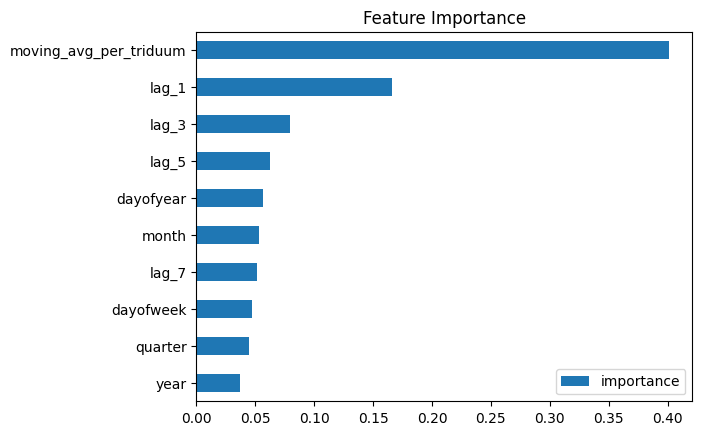

In [71]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# **Model Evaluation**

In [72]:
test['forecast'] = reg.predict(X_test)
bm_branded = bm_branded.merge(test[['forecast']], how='left', left_index=True, right_index=True)

In [73]:
filtered_data = bm_branded.iloc[split_index:]

In [74]:
test['error'] = np.abs(test[TARGET] - test['forecast'])
test['date'] = test.index.date

In [75]:
actual_values = test['avg_harga_brand']
predicted_values = test['forecast']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

lgbm_results = pd.DataFrame([{
    'Model': 'XGBRegressor',
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
}])
results = pd.concat([results, lgbm_results], ignore_index=True)

In [76]:
# Worst predicted
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2024-02-17    6.556003
2024-02-15    6.447888
2024-02-18    5.385410
2024-02-19    4.268777
2024-02-13    3.764641
Name: error, dtype: float64

In [77]:
# Best predicted
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2024-02-01    0.025821
2024-02-23    0.029557
2024-02-08    0.180292
2024-02-14    0.203078
2024-02-09    0.243973
Name: error, dtype: float64

# **Error Margin 10 Pound Treshold**

In [78]:
xgb_error = check_large_prediction_errors(test[['avg_harga_brand', 'forecast']])

In [79]:
xgb_error

Empty DataFrame
Columns: [avg_harga_brand, forecast]
Index: []

# **Forecast**

In [80]:
last_date_in_test = test.index.max()
forecast_dates = pd.date_range(last_date_in_test + timedelta(days=1), periods=30, freq='D')
forecast_predictions = reg.predict(X_test)

bm_forecasted = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_predictions})
bm_forecasted['date'] = pd.to_datetime(bm_forecasted['date'])
bm_forecasted.index = bm_forecasted.pop('date')
bm_forecasted.sort_index(inplace=True)

In [81]:
filtered_data = bm_branded.iloc[split_index:]

trace1 = go.Scatter(x=filtered_data.index, y=filtered_data['avg_harga_brand'], mode='lines', opacity=1, name='Truth Data')
trace2 = go.Scatter(x=bm_forecasted.index, y=bm_forecasted['forecast'], mode='lines', opacity=1, name='XGBRegressor')
layout = go.Layout(title='Forecast', xaxis=dict(title='Date'), yaxis=dict(title='Average Harga Brand'), legend=dict(x=0, y=1))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# ---------------------------

In [82]:
param_dist = {
    'n_estimators': randint(100, 10001),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rfr_model = RandomForestRegressor()

random_search_rfr = RandomizedSearchCV(estimator=rfr_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   cv=5, verbose=1, n_jobs=-1, random_state=42)

random_search_rfr.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search_rfr.best_params_)
print("Best cross-validation RMSE: ", (-random_search_rfr.best_score_) ** 0.5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 3173}
Best cross-validation RMSE:  4.297440253618835


# **Random Forest Regressor**

In [83]:
train_rfr = train.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
test_rfr = test.loc[:, ['avg_harga_brand', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'moving_avg_per_triduum', 'lag_1', 'lag_3', 'lag_5', 'lag_7']]
bm_branded_rfr = bm_branded.copy()

In [84]:
rfr = RandomForestRegressor(n_estimators=10000,
                            max_depth=9,
                            min_samples_leaf=3,
                            verbose=1000)
rfr.fit(X_train, y_train)

building tree 1 of 10000
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
building tree 2 of 10000
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
building tree 3 of 10000
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
building tree 4 of 10000
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
building tree 5 of 10000
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
building tree 6 of 10000
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
building tree 7 of 10000
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
building tree 8 of 10000
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
building tree 9 of 10000
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
building tree 10 of 10000
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
building tree 11 of 10000
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
building tree 12 of 10000
[Parallel(n_jobs=1)]: Done

RandomForestRegressor(max_depth=9, min_samples_leaf=3, n_estimators=10000,
                      verbose=1000)

# **Model Evaluation**

In [85]:
test_rfr['forecast'] = rfr.predict(X_test)
bm_branded_rfr = bm_branded_rfr.merge(test_rfr[['forecast']], how='left', left_index=True, right_index=True)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [86]:
rfr_forecasted = bm_branded_rfr.iloc[split_index:]

In [87]:
test_rfr['error'] = np.abs(test_rfr[TARGET] - test_rfr['forecast'])
test_rfr['date'] = test_rfr.index.date

In [88]:
actual_values = test_rfr['avg_harga_brand']
predicted_values = test_rfr['forecast']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

rfr_results = pd.DataFrame([{
    'Model': 'RandomForestRegressor',
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
}])
results = pd.concat([results, rfr_results], ignore_index=True)

# ---------------------------

# **Metrics Evaluation**

In [89]:
results

Model       MAE       MAPE        MSE      RMSE  \
0                        SARIMAX  1.894972  20.320370   8.197960  2.863208   
1                  LGBMRegressor  1.810491  18.299234   8.152925  2.855333   
2  HistGradientBoostingRegressor  2.291561  23.913830  12.307995  3.508275   
3                   XGBRegressor  1.584855  15.718301   5.935001  2.436186   
4          RandomForestRegressor  1.485052  14.996149   6.020107  2.453591   

         R2  
0  0.623912  
1  0.625978  
2  0.435361  
3  0.727727  
4  0.723823